In [1]:
import json
import os

from datetime import datetime, timezone
from dateutil import tz

import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns

TZ = pytz.timezone('America/Los_Angeles')
sns.set_style('whitegrid')

In [2]:
# Location for the local data
path = './transit_vis/data/to_upload'
files = os.listdir(path)

# Join all the data which is saved in different csv for each day
# frames = [pd.read_csv(f"{path}/{filename}", dtype={'trip_short_name': str, 'route_short_name': str}) for filename in files]
# all_data = pd.concat(frames)
# all_data.to_csv(f"{path}/../all_data.csv")
# all_data.head()

# If already processed, load the data here and comment out above
all_data = pd.read_csv(f"{path}/../all_data.csv", dtype={'trip_short_name': str, 'route_short_name': str})

# Rename and style
# all_data['speed_m_s'] = all_data['avg_speed_m_s']
#all_data = all_data[all_data['at_stop'] == True]
sns.set_style('whitegrid')

In [3]:
all_data['speed_mph'] = all_data['speed_m_s']*2.237
all_data['pace_s_mi'] = 1 / (all_data['speed_m_s']*.0006214)

In [4]:
print(all_data.columns)
all_data.head()

Index(['Unnamed: 0', 'tripid', 'vehicleid', 'lat', 'lon', 'orientation',
       'scheduledeviation', 'prev_deviation', 'totaltripdistance',
       'tripdistance', 'prev_tripdistance', 'closeststop', 'nextstop',
       'prev_stopid', 'locationtime', 'prev_locationtime', 'dist_diff',
       'time_diff', 'speed_m_s', 'deviation_change_s', 'at_stop', 'route_id',
       'trip_short_name', 'route_short_name', 'seg_compkey', 'seg_length',
       'seg_route_id', 'seg_lat', 'seg_lon', 'speed_mph', 'pace_s_mi'],
      dtype='object')


Unnamed: 0      tripid  vehicleid        lat         lon  orientation  \
0           0  34746102.0       8188  47.580441 -122.152702          180   
1           1  34746102.0       8188  47.579819 -122.147911          358   
2           2  34746102.0       8188  47.579685 -122.144455          358   
3           3  34746102.0       8188  47.581799 -122.142326          133   
4           4  34746102.0       8188  47.585056 -122.142754           90   

   scheduledeviation  prev_deviation  totaltripdistance  tripdistance  ...  \
0                 80            48.0       21489.267668     10.359279  ...   
1                 42            80.0       21489.267668    517.963526  ...   
2                  6            42.0       21489.267668    771.837350  ...   
3                 -1             6.0       21489.267668   1207.902715  ...   
4                -42            -1.0       21489.267668   1572.377132  ...   

   route_id  trip_short_name  route_short_name  seg_compkey  seg_length  \
0    100162            LOCAL               271       493119        2341   
1    100162            LOCAL               271       493119        2341   
2    100162            LOCAL               271       493119        2341   
3    100162            LOCAL               271       493119        2341   
4    100162            LOCAL               271       493119        2341   

   seg_route_id  seg_lat    seg_lon  speed_mph   pace_s_mi  
0        100162  47.6409 -122.25898      0.000         inf  
1        100162  47.6409 -122.25898     26.844  134.105783  
2        100162  47.6409 -122.25898     44.740   80.463470  
3        100162  47.6409 -122.25898     13.422  268.211565  
4        100162  47.6409 -122.25898     29.081  123.789953  

[5 rows x 31 columns]

In [5]:
print(f"Num unique vehicles: {len(pd.unique(all_data['vehicleid']))}")
print(f"Num unique segments: {len(pd.unique(all_data['seg_compkey']))}")
print(f"Num delays at stop: {len(all_data[all_data['at_stop']==True])}")

Num unique vehicles: 1314
Num unique segments: 12308
Num delays at stop: 4233552


In [6]:
4233552/len(all_data)

0.5026896266012459

### Univariate Distributions

Text(0.5, 0, 'Deviation Change (s)')

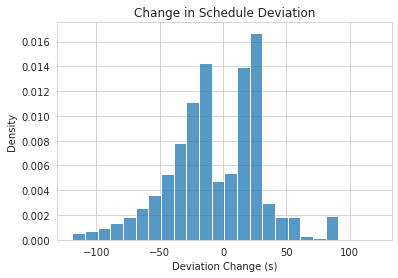

In [7]:
sns.histplot(data=all_data[(all_data['deviation_change_s']<120) & (all_data['deviation_change_s']>-120)], x='deviation_change_s', stat='density', binwidth=10)
plt.title('Change in Schedule Deviation')
plt.ylabel('Density')
plt.xlabel('Deviation Change (s)')

Text(0.5, 0, 'Speed (mph)')

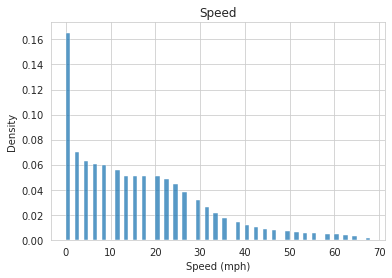

In [8]:
sns.histplot(data=all_data, x='speed_mph', stat='density', binwidth=1)
plt.title('Speed')
plt.ylabel('Density')
plt.xlabel('Speed (mph)')

Text(0.5, 0, 'Pace (s/mi)')

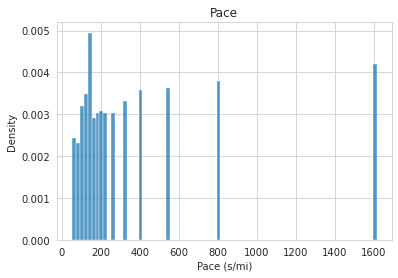

In [9]:
sns.histplot(data=all_data[all_data['pace_s_mi']<9999999], x='pace_s_mi', stat='density', binwidth=20)
plt.title('Pace')
plt.ylabel('Density')
plt.xlabel('Pace (s/mi)')

### Spatial Heatmaps

In [22]:
# Need to sample to run on normal computer
sampled = all_data.sample(1000000)
# del all_data

In [39]:
# Get daily metric for deviation change
dates = []
times = sampled.locationtime.values
TZ = pytz.timezone('America/Los_Angeles')
for time in times:
    dates.append(datetime.utcfromtimestamp(time).replace(tzinfo=pytz.utc).astimezone(TZ).strftime('%m_%d_%Y'))
sampled['day'] = dates
to_plot_med = sampled.groupby(['day', 'seg_compkey']).sum()[['deviation_change_s']].reset_index()
to_plot_med = sampled.groupby(['seg_compkey']).median()[['deviation_change_s']].reset_index()

# Get overall performance metric for speed
to_plot_spd = sampled.groupby(['seg_compkey']).median()[['speed_mph', 'deviation_change_s', 'pace_s_mi']]
to_plot_95 = sampled.groupby(['seg_compkey']).quantile(.95)[['speed_mph']]
to_plot = pd.merge(to_plot_95, to_plot_spd, on='seg_compkey')
#to_plot = pd.merge(to_plot, to_plot_med, on='seg_compkey')
to_plot['performance'] = to_plot['speed_mph_y'] / to_plot['speed_mph_x']
to_plot['performance'] = np.nan_to_num(to_plot['performance'])
metric_lookup = to_plot.to_dict(orient='index')

# Keep track of all values for the linear colormapping
speeds = np.array(to_plot['speed_mph_y'])
deviations = np.array(to_plot['deviation_change_s'])
performances = np.array(to_plot['performance'])
paces = np.nan_to_num(np.array(to_plot['pace_s_mi']))

# Write speeds from dict to temp geojson file
with open(f"{path}/../streets_0001buffer.geojson", 'r') as shapefile:
    streets = json.load(shapefile)
for feature in streets['features']:
    compkey = feature['properties']['COMPKEY']
    if compkey in metric_lookup.keys():
        speed = metric_lookup[compkey]['speed_mph_y']
        dev_change = metric_lookup[compkey]['deviation_change_s']
        performance = metric_lookup[compkey]['performance']
        pace = metric_lookup[compkey]['pace_s_mi']
        feature['properties']['MED_SPEED_M_S'] = speed
        feature['properties']['DEVIATION_CHG_S'] = dev_change
        feature['properties']['PERFORMANCE'] = performance
        feature['properties']['PACE'] = pace
    else:
        feature['properties']['MED_SPEED_M_S'] = 0
        feature['properties']['DEVIATION_CHG_S'] = 0
        feature['properties']['PERFORMANCE'] = 0
        feature['properties']['PACE'] = 0
with open(f"{path}/../streets_0001buffer_tmp.geojson", 'w+') as new_shapefile:
    json.dump(streets, new_shapefile)

In [52]:
# Initialize the map
f_map = folium.Map(
    location=[47.606209, -122.332069],
    zoom_start=11,
    prefer_canvas=True)

# Add street segments

# linear_cm_spd = cm.LinearColormap(
#     ['red', 'white', 'blue'],
#     vmin=np.min(speeds),
#     vmax=np.percentile(speeds, 95))
# folium.GeoJson(
#     name='Seattle Streets Median Speed',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['MED_SPEED_M_S'] == 0 \
#             else linear_cm_spd(feature['properties']['MED_SPEED_M_S']),
#         'weight': 2 if feature['properties']['MED_SPEED_M_S'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['MED_SPEED_M_S'],
#         aliases=['Speed (m/s)'])
# ).add_to(f_map)
# linear_cm_spd.add_to(f_map)

linear_cm_dev = cm.LinearColormap(
    ['blue', 'white', 'red'],
    vmin=np.percentile(deviations, 1),
    vmax=np.percentile(deviations, 99))
folium.GeoJson(
    name='Seattle Streets Median Deviation Change',
    data=f"{path}/../streets_0001buffer_tmp.geojson",
    style_function=lambda feature: {
        'color': 'gray' if feature['properties']['DEVIATION_CHG_S'] == 0 \
            else linear_cm_dev(feature['properties']['DEVIATION_CHG_S']),
        'weight': 2 if feature['properties']['DEVIATION_CHG_S'] == 0 \
            else 3},
    highlight_function=lambda feature: {
        'fillColor': '#ffaf00', 'color': 'blue', 'weight': 3},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['DEVIATION_CHG_S'],
        aliases=['Deviation Change (s)'])
).add_to(f_map)
linear_cm_dev.add_to(f_map)

# linear_cm_per = cm.LinearColormap(
#     ['red', 'white', 'blue'],
#     #vmin=np.min(performances),
#     vmin=np.percentile(performances, 0),
#     vmax=np.percentile(performances, 100))
# folium.GeoJson(
#     name='Seattle Streets Performance',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['PERFORMANCE'] == 0 \
#             else linear_cm_per(feature['properties']['PERFORMANCE']),
#         'weight': 2 if feature['properties']['PERFORMANCE'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['PERFORMANCE'],
#         aliases=['Median Speed / 95th Percentile'])
# ).add_to(f_map)
# linear_cm_per.add_to(f_map)

# linear_cm_per = cm.LinearColormap(
#     ['blue', 'white', 'red'],
#     vmin=np.percentile(paces, 0),
#     vmax=np.percentile(paces, 90))
# folium.GeoJson(
#     name='Seattle Streets Pace',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['PACE'] == 0 \
#             else linear_cm_per(feature['properties']['PACE']),
#         'weight': 2 if feature['properties']['PACE'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['PACE'],
#         aliases=['1 / Median Speed'])
# ).add_to(f_map)
# linear_cm_per.add_to(f_map)

# Create and add layer for all the sampled coordinate data
# lats = sampled['lat'].tolist()
# lons = sampled['lon'].tolist()
# points = zip(lats, lons)
# points = list(points)
# HeatMap(
#     data=points,
#     name='Points',
#     radius=8,
#     min_opacity=0.2
# ).add_to(f_map)


folium.GeoJson(
    name='Study Corridors',
    data=f"{path}/../study_corridors.geojson",
    style_function=lambda feature: {
        'color': 'purple',
        'weight': 4
    }
).add_to(f_map)
folium.LayerControl().add_to(f_map)

# Save map and plot in notebook
f_map.save(f"./local_sampled_map.html")
f_map